In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/content/sample_data/formspring_data.csv',delimiter='\t',quoting=3)

In [3]:
df = df[['ques','ans1']]  #limiting to question and answer 
#replacing html symbols
df['ques'] = df['ques'].str.replace('&#039;',' ')
df['ques'] = df['ques'].str.replace('&quot;',' ')
df['ques'] = df['ques'].str.replace('<br>',' ')    

In [4]:
df = df.dropna()
positives = df[df['ans1']=='Yes']
negatives = df[df['ans1']=='No']
frames = [positives,negatives]

In [5]:
df = pd.concat(frames)
df = df.sample(frac=1)

In [6]:
df['ans1'] = df['ans1'].replace(('Yes','No'),(1,0))
bag = []
def clean_data(sentence):
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = sentence.lower().split()
    words = [word for word in sentence if not word in stopwords.words('english')]
    sentence = ' '.join(words)
    bag.append(sentence)

In [7]:
df['ans1'].value_counts()

0    11691
1     1038
Name: ans1, dtype: int64

In [8]:
import re
df['ques'].apply(clean_data)

8462     None
2195     None
10281    None
3047     None
8737     None
         ... 
4046     None
792      None
4400     None
8349     None
9203     None
Name: ques, Length: 12729, dtype: object

In [9]:
tokenizer = Tokenizer(num_words=20000)

In [10]:
X = df['ques'].values
tokenizer.fit_on_texts(X)
print(tokenizer.word_index)

{'you': 1, 'i': 2, 'a': 3, 'the': 4, 'to': 5, 'do': 6, 'what': 7, 'your': 8, 'is': 9, 'and': 10, 'it': 11, 'have': 12, 'in': 13, 'of': 14, 'u': 15, 'or': 16, 'are': 17, 'if': 18, 'would': 19, 'that': 20, 'like': 21, 'on': 22, 'me': 23, 'how': 24, 'be': 25, 'for': 26, 's': 27, 'ever': 28, 'my': 29, 'apos': 30, 'so': 31, 'why': 32, 'with': 33, 'who': 34, 'was': 35, 'think': 36, 'not': 37, 'r': 38, 'know': 39, 'lol': 40, 'when': 41, 't': 42, 'd': 43, 'love': 44, 'can': 45, 'one': 46, 'just': 47, 'about': 48, 'get': 49, 'but': 50, 'did': 51, 'up': 52, 'at': 53, '3': 54, 'people': 55, 'this': 56, 'im': 57, 'they': 58, 'go': 59, 'out': 60, 'ur': 61, 'all': 62, 'want': 63, 'were': 64, 'm': 65, 'there': 66, 'time': 67, 'someone': 68, 'now': 69, 'favorite': 70, 'haha': 71, 'had': 72, 'no': 73, 'from': 74, 'any': 75, 'as': 76, 'could': 77, 'them': 78, 'p': 79, 'last': 80, '39': 81, 'most': 82, 'say': 83, 'we': 84, 'been': 85, 'life': 86, 're': 87, 'person': 88, 'an': 89, 'thing': 90, 'really': 9

In [11]:
len(tokenizer.word_index)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X,maxlen=250)

In [12]:
y = df['ans1'].values.astype(int)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [16]:
from tensorflow.keras.layers import Embedding
model = Sequential()
model.add(Embedding(20000,120))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear')) #regression
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         2400000   
_________________________________________________________________
dense_3 (Dense)              (None, None, 8)           968       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           9         
Total params: 2,400,977
Trainable params: 2,400,977
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])


In [18]:
history = model.fit(X_train,y_train,batch_size=45,epochs=3,verbose=2,validation_data=(X_test,y_test))

Epoch 1/3
213/213 - 7s - loss: 0.4383 - accuracy: 0.9183 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3044 - val_accuracy: 0.9189 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/3
213/213 - 6s - loss: 0.3029 - accuracy: 0.9183 - f1_m: 0.0485 - precision_m: 0.1002 - recall_m: 0.0363 - val_loss: 0.3042 - val_accuracy: 0.9190 - val_f1_m: 0.2039 - val_precision_m: 0.3486 - val_recall_m: 0.1661
Epoch 3/3
213/213 - 6s - loss: 0.3006 - accuracy: 0.9183 - f1_m: 0.2373 - precision_m: 0.3891 - recall_m: 0.2000 - val_loss: 0.3013 - val_accuracy: 0.9191 - val_f1_m: 0.3756 - val_precision_m: 0.4941 - val_recall_m: 0.5299


In [19]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test,batch_size=45,verbose=2)

71/71 - 0s - loss: 0.3013 - accuracy: 0.9191 - f1_m: 0.3756 - precision_m: 0.4941 - recall_m: 0.5299


In [29]:
from sklearn.metrics import roc_curve


In [23]:
y_pred = model.predict(X_test)

In [34]:
results = []
for result in y_pred:
  results.append(result[-1][0])

In [36]:
results = np.array(results)

In [37]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, results)

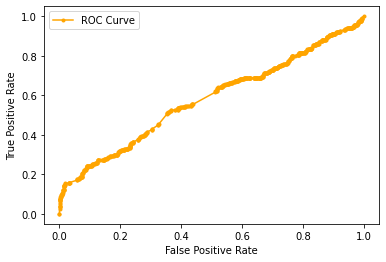

In [38]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()